<h1><center> MODELLING INVESTMENT STRATEGIES </center></h1>
<h2><center> PART 1. NON-INTELLIGENT ALGORITHMS </center></h2>

## 1. SOURCES

This section is based on the resources created by the Google Research Community in the field of Finance. The must updated version is available at:

https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW

## 2.THE DATA FILE

In [1]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
#sns.set()

D:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We can import the data directly from `Yahoo Finance` by running the commented cell bellow. For portability, we recommed to load the data directly from a file located in the our working directory. 

In [2]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
df_full = pdr.get_data_yahoo("JPM", start="2000-01-01").reset_index()
df_full.to_csv('JPM.csv',index=False)
df_full.head()


D:\Program Files\Anaconda\lib\site-packages\fix_yahoo_finance\__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,50.250000,48.083332,49.833332,48.583332,12019200.0,26.681709
1,2000-01-04,47.458332,46.125000,47.083332,47.250000,11723400.0,26.170267
2,2000-01-05,48.375000,46.000000,46.833332,46.958332,8714500.0,26.008717
3,2000-01-06,48.625000,46.500000,46.750000,47.625000,8369200.0,26.377962
4,2000-01-07,49.000000,47.333332,48.416668,48.500000,6571900.0,26.862602


In [3]:
df_full = pd.read_csv('JPM.csv')

##  3. TURTLE TRADING

Turtle is a nickname given to a group of traders who were part of a 1983 experiment run by two famous commodity traders, Richard Dennis and Bill Eckhardt. Dennis named the participants in the experiment turtles in reference to the farm-grown turtles that he witnessed during his travels abroad.

In the early 1980s, Richard Dennis and Bill Eckhardt took out a large newspaper ad looking for trading apprentices in Barron’s, The Wall Street Journal and The New York Times. Since Richard was a famous trader, the team received more than 1,000 applications. They then culled this list to produce their group of 10 turtles. These 10 participants were then invited to Chicago for two weeks of training. Once trained, they were given money and trading accounts to implement the trading strategy.

The turtles became one of the most famous experiments in financial history because they ended up generating returns in excess of an 80 percent compounded rate over the next four years. Dennis’s experiment seemed to demonstrate that traders could be taught a relatively simple set of rules with little or no trading experience and become excellent traders. Since then, several books and subscription services have been published offering to teach investors how to use the turtle trading system.

The trading system itself came to be known as the turtle trading system, and is purported to cover all the decisions required for successful trading. This includes what markets to trade in, how to determine your position size, and when to enter and exit positions. 

The underlying logic behind the system is that traders should not let their own judgment cloud their decision-making. Instead, they should diligently follow the rules set out in the system.

Some of the specific ideas used in the turtle trading system include the use of limit orders instead of market orders, and the use of breakouts from key moving averages as trading signals indicating when to buy and sell. The system also advocates gradually building up experience before trading with larger amounts of money.


### INVESTMENT RULE

In [4]:
df= df_full.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,48.583332,NaN,NaN
1,0.0,47.250000,NaN,NaN
2,0.0,46.958332,NaN,NaN
3,0.0,47.625000,NaN,NaN
4,0.0,48.500000,NaN,NaN
...,...,...,...,...
5052,0.0,133.369995,141.089996,92.139999
5053,0.0,135.289993,141.089996,92.139999
5054,0.0,137.589996,141.089996,92.139999
5055,0.0,137.610001,141.089996,92.139999


### VISUALIZATION OF INVESTMENT RULES

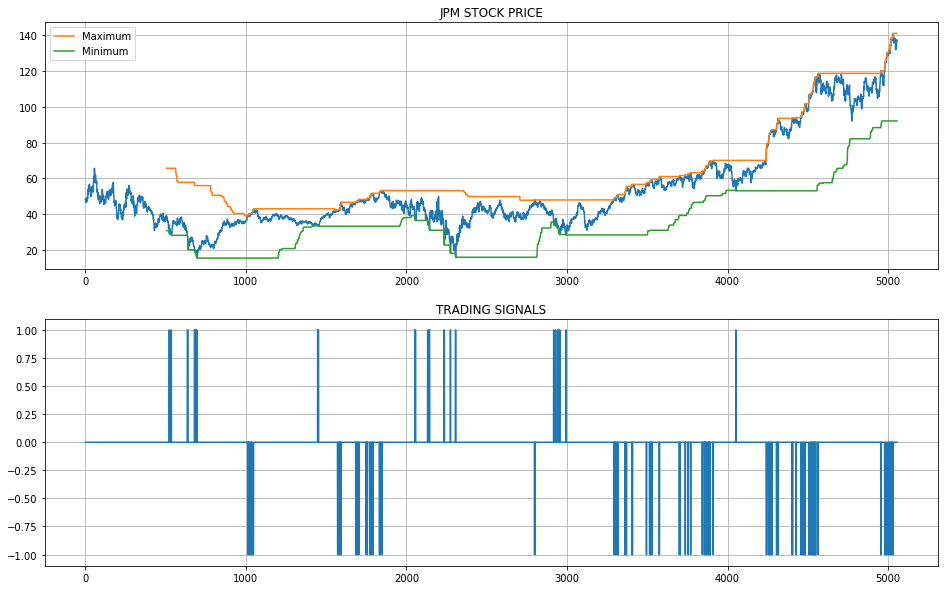

In [5]:
fig, (ax1,ax2)=plt.subplots(2,figsize=(16,10))

ax1.plot(signals['trend'])
line1,= ax1.plot(signals['RollingMax'], label="Maximum")
line2, =ax1.plot(signals['RollingMin'], label="Minimum")

ax1.legend(handles=[line1,line2], loc='upper left')
ax1.grid()
ax1.set_title("JPM STOCK PRICE")
ax2.plot(signals['signal'])
ax2.set_title("TRADING SIGNALS")
ax2.grid()
plt.show()


### BACKTESTING CALCULATOR
#### PARAMETERS

 > - real_movement = actual movement in the real world
 > - delay = how much interval you want to delay to change our decision from buy to sell, vice versa
 > - initial_state = 1 is buy, 0 is sell
 > - initial_money = 1000, ignore what kind of currency
 > - max_buy = max quantity for share to buy
 > - max_sell = max quantity for share to sell
    

In [6]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1):
   
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

#### TRADING RECORD

In [7]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 522: buy 1 units at price 30.559999, total balance 9969.440001
day 523: buy 1 units at price 29.020000, total balance 9940.420000
day 535: buy 1 units at price 28.190001, total balance 9912.230000
day 635: buy 1 units at price 28.139999, total balance 9884.090000
day 636: buy 1 units at price 27.200001, total balance 9856.889999
day 637: buy 1 units at price 26.100000, total balance 9830.789999
day 638: buy 1 units at price 24.520000, total balance 9806.269999
day 639: buy 1 units at price 20.080000, total balance 9786.189999
day 680: buy 1 units at price 19.870001, total balance 9766.319998
day 682: buy 1 units at price 19.250000, total balance 9747.069998
day 683: buy 1 units at price 18.639999, total balance 9728.429998
day 686: buy 1 units at price 18.340000, total balance 9710.089998
day 689: buy 1 units at price 18.250000, total balance 9691.839998
day 690: buy 1 units at price 17.620001, total balance 9674.219997
day 691: buy 1 units at price 16.540001, total balance 9657.67

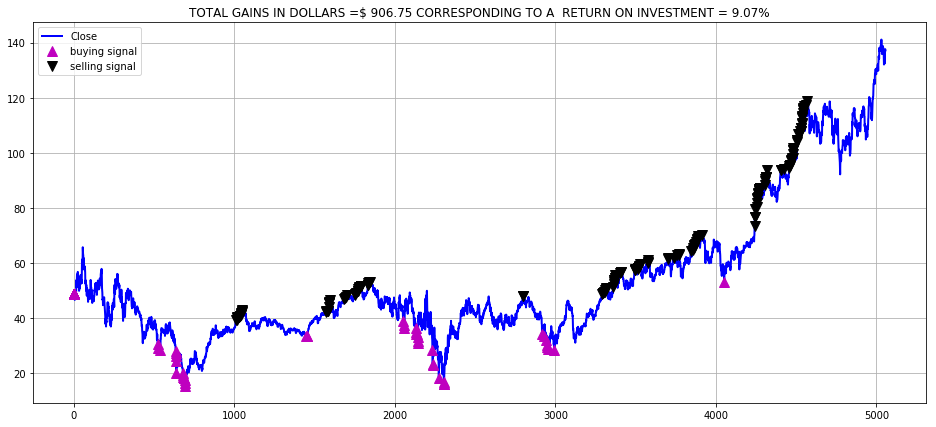

In [8]:
close = df['Close']
fig = plt.figure(figsize = (16,7))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TOTAL GAINS IN DOLLARS =$ %.2f CORRESPONDING TO A  RETURN ON INVESTMENT = %.2f%%'%(total_gains, invest))
plt.grid()
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()


## 3. MOVING AVERAGE AGENT

In the statistics of time series, and in particular the analysis of financial time series for stock trading purposes, a moving-average crossover occurs when, on plotting two moving averages each based on different degrees of smoothing, the traces of these moving averages cross. It does not predict future direction but shows trends. This indicator uses two (or more) moving averages, a slower moving average and a faster moving average. The faster moving average is a short term moving average. For end-of-day stock markets, for example, it may be 5-, 10- or 25-day period while the slower moving average is medium or long term moving average (e.g. 50-, 100- or 200-day period). A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic. However, it tends to smooth out price noises which are often reflected in short term moving averages.

A moving average, as a line by itself, is often overlaid in price charts to indicate price trends. A crossover occurs when a faster moving average (i.e., a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In other words, this is when the shorter period moving average line crosses a longer period moving average line. In stock investing, this meeting point is used either to enter (buy or sell) or exit (sell or buy) the market.

The particular case where simple equally weighted moving-averages are used is sometimes called a simple moving-average (SMA) crossover. Such a crossover can be used to signal a change in trend and can be used to trigger a trade in a Black Box trading system.

### INVESTMENT RULE

In [9]:
df= df_full.copy()
name = 'Moving Average agent'

short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,48.583332,48.583332,NaN
1,0.0,47.916666,47.916666,0.0
2,0.0,47.597221,47.597221,0.0
3,0.0,47.604166,47.604166,0.0
4,0.0,47.783333,47.783333,0.0
...,...,...,...,...
5052,1.0,124.591905,116.793651,0.0
5053,1.0,124.796031,116.916825,0.0
5054,1.0,125.011587,117.050952,0.0
5055,1.0,125.246349,117.185357,0.0


### VISUALIZATION

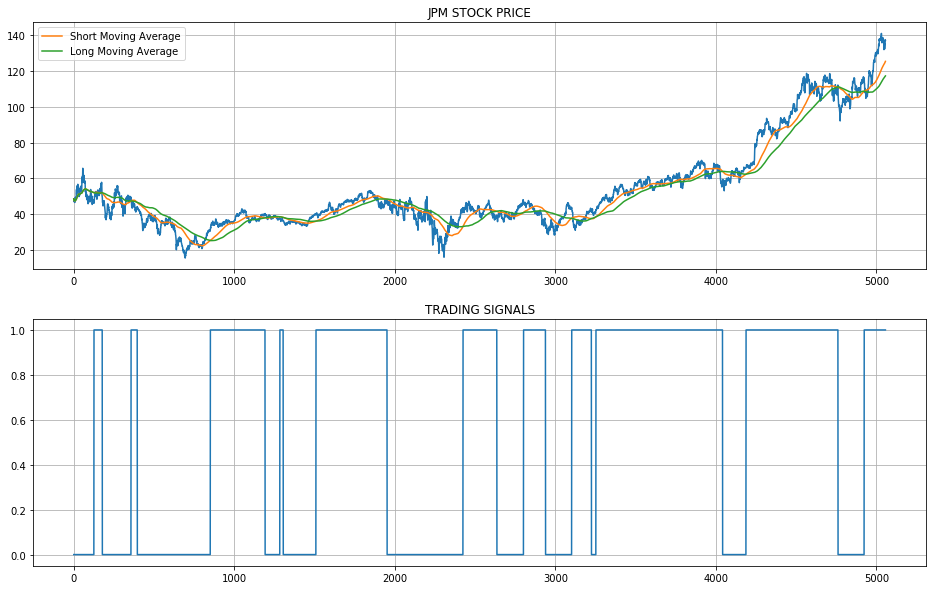

In [10]:
signals["trend"] = df['Close']
fig, (ax1,ax2)=plt.subplots(2,figsize=(16,10))

ax1.plot(signals['trend'])
line1,= ax1.plot(signals['short_ma'], label="Short Moving Average")
line2, =ax1.plot(signals['long_ma'], label="Long Moving Average")

ax1.legend(handles=[line1,line2], loc='upper left')
ax1.grid()
ax1.set_title("JPM STOCK PRICE")
ax2.plot(signals['signal'])
ax2.set_title("TRADING SIGNALS")
ax2.grid()
plt.show()

### BACKTESTING CALCULATOR

In [11]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [12]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 126: buy 1 units at price 47.562500, total balance 9952.437500
day 178, sell 1 units at price 49.125000, investment 3.285151 %, total balance 10001.562500,
day 357: buy 1 units at price 49.500000, total balance 9952.062500
day 396, sell 1 units at price 43.810001, investment -11.494947 %, total balance 9995.872501,
day 851: buy 1 units at price 32.049999, total balance 9963.822502
day 1192, sell 1 units at price 40.340000, investment 25.865838 %, total balance 10004.162502,
day 1284: buy 1 units at price 37.480000, total balance 9966.682503
day 1305, sell 1 units at price 36.250000, investment -3.281749 %, total balance 10002.932503,
day 1509: buy 1 units at price 39.619999, total balance 9963.312504
day 1952, sell 1 units at price 47.570000, investment 20.065626 %, total balance 10010.882504,
day 2425: buy 1 units at price 43.580002, total balance 9967.302502
day 2636, sell 1 units at price 38.540001, investment -11.564940 %, total balance 10005.842503,
day 2802: buy 1 units at pr

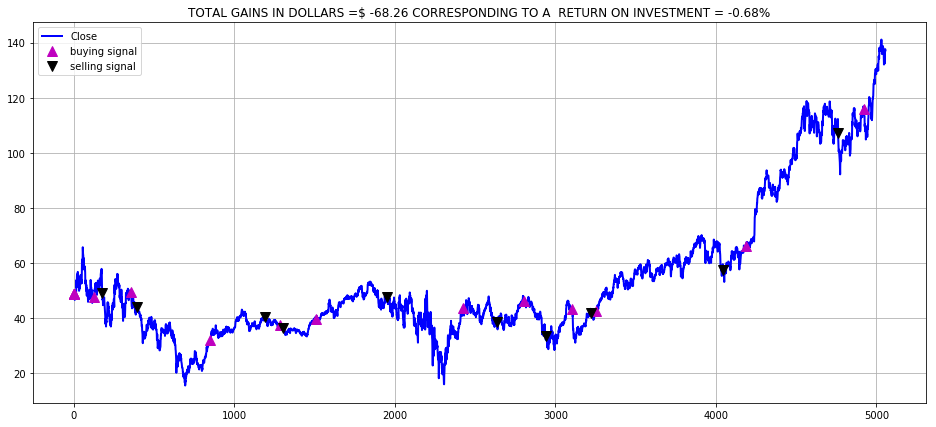

In [13]:
close = df['Close']
fig = plt.figure(figsize = (16,7))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TOTAL GAINS IN DOLLARS =$ %.2f CORRESPONDING TO A  RETURN ON INVESTMENT = %.2f%%'%(total_gains, invest))
plt.grid()
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## 3. SIGNAL ROLLING AGENT

This strategy relies in using the same moving average triggers for purchases or sales, with the caveat of adding a `delay` parameter. What is done is simply to compare the current value of the stock and compare it with a value in the past. What we do here is to buy the stock in the current price is higher than the delayed price and viceversa.

###  DATA

In [31]:
df= df_full.copy()
name = 'Signal Rolling agent'

### INVESTMENT RULE AND BACKTESTING CALCULATOR

In [32]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [33]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 48.583332, total balance 9951.416668
day 9, sell 1 units at price 49.250000, investment 1.372215 %, total balance 10000.666668,
day 21: buy 1 units at price 54.916668, total balance 9945.750000
day 30, sell 1 units at price 54.041668, investment -1.593323 %, total balance 9999.791668,
day 37: buy 1 units at price 50.583332, total balance 9949.208336
day 43, sell 1 units at price 55.625000, investment 9.967054 %, total balance 10004.833336,
day 53: buy 1 units at price 57.708332, total balance 9947.125004
day 66, sell 1 units at price 58.291668, investment 1.010835 %, total balance 10005.416672,
day 73: buy 1 units at price 52.416668, total balance 9953.000004
day 90, sell 1 units at price 46.666668, investment -10.969793 %, total balance 9999.666672,
day 99: buy 1 units at price 47.750000, total balance 9951.916672
day 105, sell 1 units at price 53.791668, investment 12.652708 %, total balance 10005.708340,
day 110: buy 1 units at price 48.875000, total bala

### VISUALIZATION OF THE RESULTS

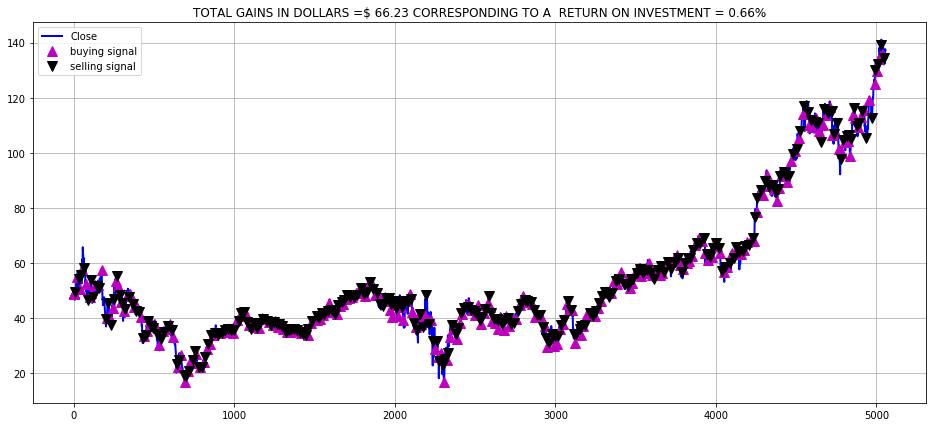

In [34]:
close = df['Close']
fig = plt.figure(figsize = (16,7))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TOTAL GAINS IN DOLLARS =$ %.2f CORRESPONDING TO A  RETURN ON INVESTMENT = %.2f%%'%(total_gains, invest))
plt.grid()
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## 4. CONCLUSIONS

In the particular case of the JPM stock, the result of these strategies are insignificantly different from buying and holding the stock over the extended period. This could make a case for continuing exploring more refined algorithms.